In [70]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import datetime as dt
from datetime import datetime
sns.set_style('whitegrid')
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import os

In [71]:
os.chdir("C:/Users/user/Desktop/trade_machine")

In [72]:
data = pd.read_csv('data/raw_df.csv')

In [73]:
data = data[['time_id','realized_volatility', 'num_trades',
       'highest_return', 'high_low_gap', 'trade_vol', 'volume_power',
       'dv1_realized_volatility', 'realized_volatility_150', 'num_trades_150',
       'highest_return_150', 'high_low_gap_150', 'trade_vol_150',
       'volume_power_150', 'realized_volatility_300', 'num_trades_300',
       'highest_return_300', 'high_low_gap_300', 'trade_vol_300',
       'volume_power_300', 'realized_volatility_450', 'num_trades_450',
       'highest_return_450', 'high_low_gap_450', 'trade_vol_450',
       'volume_power_450', 'liq_last_1', 'liq_last_2', 'liq_last_5',
       'liq_last_10', 'liq_last_15', 'bidask_spread_0', 'bidask_spread_1',
       'liq_last_1_150', 'liq_last_2_150', 'liq_last_5_150', 'liq_last_10_150',
       'liq_last_15_150', 'bidask_spread_0_150', 'bidask_spread_1_150',
       'liq_last_1_300', 'liq_last_2_300', 'liq_last_5_300', 'liq_last_10_300',
       'liq_last_15_300', 'bidask_spread_0_300', 'bidask_spread_1_300',
       'liq_last_1_450', 'liq_last_2_450', 'liq_last_5_450', 'liq_last_10_450',
       'liq_last_15_450', 'bidask_spread_0_450', 'bidask_spread_1_450', 'tvpl',
       'trade.tau']]

# Preprocess

In [74]:
# Assuming 'data' is a pandas DataFrame

# Check for NaN and Inf values in the dataset
print("NaN values in data:", data.isna().sum().sum())
print("Inf values in data:", np.isinf(data.drop(columns=['time_id'])).sum().sum()) 

# Handle NaN and Inf values by replacing them with mean values of respective columns
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)  # Filling NaN with mean values column-wise

print("Inf values in data after replacement:", np.isinf(data.drop(columns=['time_id'])).sum().sum())  # Check again after replacement


NaN values in data: 832
Inf values in data: 157
Inf values in data after replacement: 0


C:\Users\user\AppData\Local\Temp\ipykernel_15492\2484032867.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)  # Filling NaN with mean values column-wise


In [75]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102336 entries, 0 to 102335
Data columns (total 56 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   time_id                  102336 non-null  object 
 1   realized_volatility      102336 non-null  float64
 2   num_trades               102336 non-null  int64  
 3   highest_return           102336 non-null  float64
 4   high_low_gap             102336 non-null  float64
 5   trade_vol                102336 non-null  float64
 6   volume_power             102336 non-null  float64
 7   dv1_realized_volatility  102336 non-null  float64
 8   realized_volatility_150  102336 non-null  float64
 9   num_trades_150           102336 non-null  int64  
 10  highest_return_150       102336 non-null  float64
 11  high_low_gap_150         102336 non-null  float64
 12  trade_vol_150            102336 non-null  float64
 13  volume_power_150         102336 non-null  float64
 14  real

In [76]:
data.drop(columns=['time_id'],inplace=True)

In [77]:
df = data.copy()

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
X = []
Y = []

window_size = 6
forecast_period = 1
feature_columns = list(df.columns)
feature_columns.remove('dv1_realized_volatility') 

for i in range(len(df) - window_size - forecast_period + 1):
    # For X: Use the features for the window
    temp = df.iloc[i:i + window_size][feature_columns].values
    X.append(temp)
    
    # For Y: Use the 'dv1_realized_volatility' for the next 10 minutes
    volatilities = df.iloc[i + window_size: i + window_size + forecast_period]['dv1_realized_volatility'].values
    Y.append(volatilities)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)


(102330, 6, 54)
(102330, 1)


In [80]:
split_point = int(0.9 * len(X)) 

train_X = X[:split_point]
test_X = X[split_point:]
train_Y = Y[:split_point]
test_Y = Y[split_point:]

print(train_X.shape)
print(test_X.shape)


(92097, 6, 54)
(10233, 6, 54)


In [81]:
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)


In [82]:
train_X.shape

(92097, 324)

In [83]:
print(len(X))
print(len(Y))
print(len(train_X))
print(len(test_X))

102330
102330
92097
10233


# Modeling

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


simple nn

In [46]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(5400,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='linear')) # 10 future volatilities


In [47]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error') 

In [48]:
history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
2588/2588 [==============================] - 38s 14ms/step - loss: 10602292.0000 - val_loss: 4.2881e-04
Epoch 2/10
2588/2588 [==============================] - 33s 13ms/step - loss: 24684.7812 - val_loss: 5.6522e-04
Epoch 3/10
2588/2588 [==============================] - 32s 12ms/step - loss: 9832.4922 - val_loss: 7.3146e-04
Epoch 4/10
2588/2588 [==============================] - 33s 13ms/step - loss: 6.3341e-04 - val_loss: 5.0085e-04
Epoch 5/10
2588/2588 [==============================] - 32s 13ms/step - loss: 3.1290e-04 - val_loss: 1.2799e-04
Epoch 6/10
2588/2588 [==============================] - 33s 13ms/step - loss: 3.8179e-05 - val_loss: 1.2385e-06
Epoch 7/10
2588/2588 [==============================] - 33s 13ms/step - loss: 1.4879e-07 - val_loss: 4.7271e-09
Epoch 8/10
2588/2588 [==============================] - 32s 12ms/step - loss: 6.9065e-09 - val_loss: 4.6972e-09
Epoch 9/10
2588/2588 [==============================] - 33s 13ms/step - loss: 6.9099e-09 - val_loss: 4

In [51]:
loss = model.evaluate(test_X, test_Y)
print(f"Test Loss: {loss}")


320/320 [==============================] - 1s 3ms/step - loss: 4.4733e-09
Test Loss: 4.4733172721578285e-09


In [52]:
predictions = model.predict(test_X)


320/320 [==============================] - 1s 2ms/step


cnn-gru

In [85]:
train_X = train_X.reshape(train_X.shape[0], 6, 54)
test_X = test_X.reshape(test_X.shape[0], 6, 54)


In [94]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Bidirectional, MaxPooling1D
model = tf.keras.Sequential()

# Convolutional Layers
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(6, 54)))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))  

# Bidirectional GRU Layer
model.add(Bidirectional(GRU(100, return_sequences=False)))

# Dropout for regularization
model.add(Dropout(0.5))

# Dense layer for predictions
model.add(Dense(1, activation='linear'))  # Predicting for the next 10 minutes

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])


# Fit the model
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=5, batch_size=200, verbose=1, shuffle=True)


Epoch 1/5
461/461 [==============================] - 9s 10ms/step - loss: 0.3041 - mse: 0.3041 - mae: 0.3510 - val_loss: 2.6689e-04 - val_mse: 2.6689e-04 - val_mae: 0.0101
Epoch 2/5
461/461 [==============================] - 4s 8ms/step - loss: 6.6788e-04 - mse: 6.6788e-04 - mae: 0.0152 - val_loss: 5.8195e-05 - val_mse: 5.8195e-05 - val_mae: 0.0043
Epoch 3/5
461/461 [==============================] - 4s 8ms/step - loss: 1.1219e-04 - mse: 1.1219e-04 - mae: 0.0044 - val_loss: 9.0863e-06 - val_mse: 9.0863e-06 - val_mae: 0.0018
Epoch 4/5
461/461 [==============================] - 3s 7ms/step - loss: 2.6437e-05 - mse: 2.6437e-05 - mae: 0.0017 - val_loss: 1.5335e-06 - val_mse: 1.5335e-06 - val_mae: 5.9392e-04
Epoch 5/5
461/461 [==============================] - 3s 7ms/step - loss: 5.9413e-06 - mse: 5.9413e-06 - mae: 6.2763e-04 - val_loss: 4.1431e-07 - val_mse: 4.1431e-07 - val_mae: 2.6008e-04


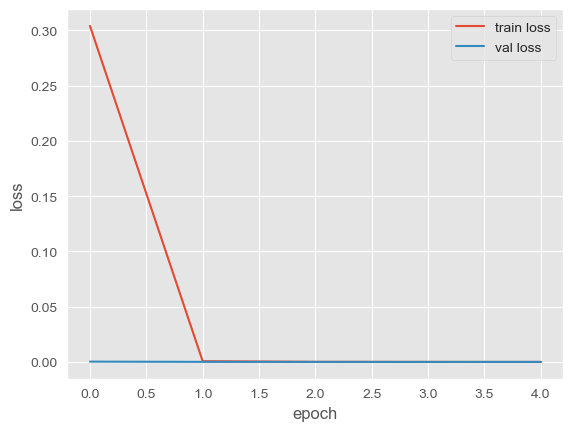

In [95]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [96]:
model.evaluate(test_X, test_Y)

320/320 [==============================] - 1s 2ms/step - loss: 4.1431e-07 - mse: 4.1431e-07 - mae: 2.6008e-04


[4.14308658491791e-07, 4.14308658491791e-07, 0.0002600804145913571]

In [97]:
# 모델 평가
loss, mse, mae = model.evaluate(test_X, test_Y)
print("Loss:", loss)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# 예측값 얻기
pred_Y = model.predict(test_X)

# RMSPE 계산 함수
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# RMSPE 값 계산 및 출력
error = rmspe(test_Y, pred_Y)
print("RMSPE:", error)


320/320 [==============================] - 1s 2ms/step - loss: 4.1431e-07 - mse: 4.1431e-07 - mae: 2.6008e-04
Loss: 4.14308658491791e-07
Mean Squared Error: 4.14308658491791e-07
Mean Absolute Error: 0.0002600804145913571
320/320 [==============================] - 1s 1ms/step
RMSPE: 4.511854917131372
